<img src="google_07_fig1.png">

Task: encode uings 'Stim'  as section of the circuit within blue rectangle

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import stim
print(stim.__version__)
import pymatching
print(pymatching.__version__)

1.16.dev0
2.3.1


In [2]:
# Our logical states are 000 and 111, so observing any single qubit tells us which logical state we have measured.

circDef1="""
# ====  initial sate
# Reset all qubits:
R 0 1 2 3 4

# apply p=1e-3 post-reset X-nosie to each qubit, independent:
X_ERROR(0.001) 0 1 2 3 4
TICK

# CNOT gates 'pointing down',  CNOT(0,1), CNOT(2,3)
CX 0 1 2 3

# apply 2q noise to each qubit touched by CX, equal chance of all 15 possible errors for a pair of qubits: IX,IY,...
DEPOLARIZE2(0.001) 0 1 2 3

# apply noise to idle qubit, depolarize meanse  p/3 of each X,Y,Z error
DEPOLARIZE1(0.001) 4
TICK

# CNOT gates 'pointing up',  
CX 2 1 4 3
DEPOLARIZE1(0.001) 0
DEPOLARIZE2(0.001) 2 1 4 3
TICK

# add error *before* measurement
X_ERROR(0.001) 1 3
M 1 3

# apply noise to idle qubit
DEPOLARIZE1(0.001) 0 2 4

# Set coordinates (x,t) of detectors and the measurements they depend on, ex. x=qubit
# The coordinates written in the DETECTOR() command are local, in particular within repeat-loop
DETECTOR(1, 0) rec[-2]
DETECTOR(3, 0) rec[-1]

#====== repeating gates
REPEAT 5 {
R 1 3
X_ERROR(0.001) 1 3
DEPOLARIZE1(0.001) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.001) 0 1 2 3
DEPOLARIZE1(0.001) 4
CX 2 1 4 3
DEPOLARIZE1(0.001) 0
DEPOLARIZE2(0.001) 2 1 4 3
X_ERROR(0.001) 1 3
M 1 3
DEPOLARIZE1(0.001) 0 2 4

#...... completion of repeat-loop, 
#  command moves that cursor by (dx, dt) immediately.
SHIFT_COORDS(0, 1) # increase t of future detectors
DETECTOR(1, 0) rec[-2] rec[-4] 
DETECTOR(3, 0) rec[-1] rec[-3]
}

# = = = ==  final measurements 
X_ERROR(0.001) 0 2 4
M 0 2 4

SHIFT_COORDS(0, 1)

#.... final detector is defined as parity of 3 measurements
DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]

# Choose the measurement(s) that make up the logical observables:
OBSERVABLE_INCLUDE(0) rec[-1]
"""

stim.Circuit('''
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    TICK
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    REPEAT 5 {
        R 1 3
        X_ERROR(0.001) 1 3
        DEPOLARIZE1(0.001) 0 2 4
        CX 0 1 2 3
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        CX 2 1 4 3
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')


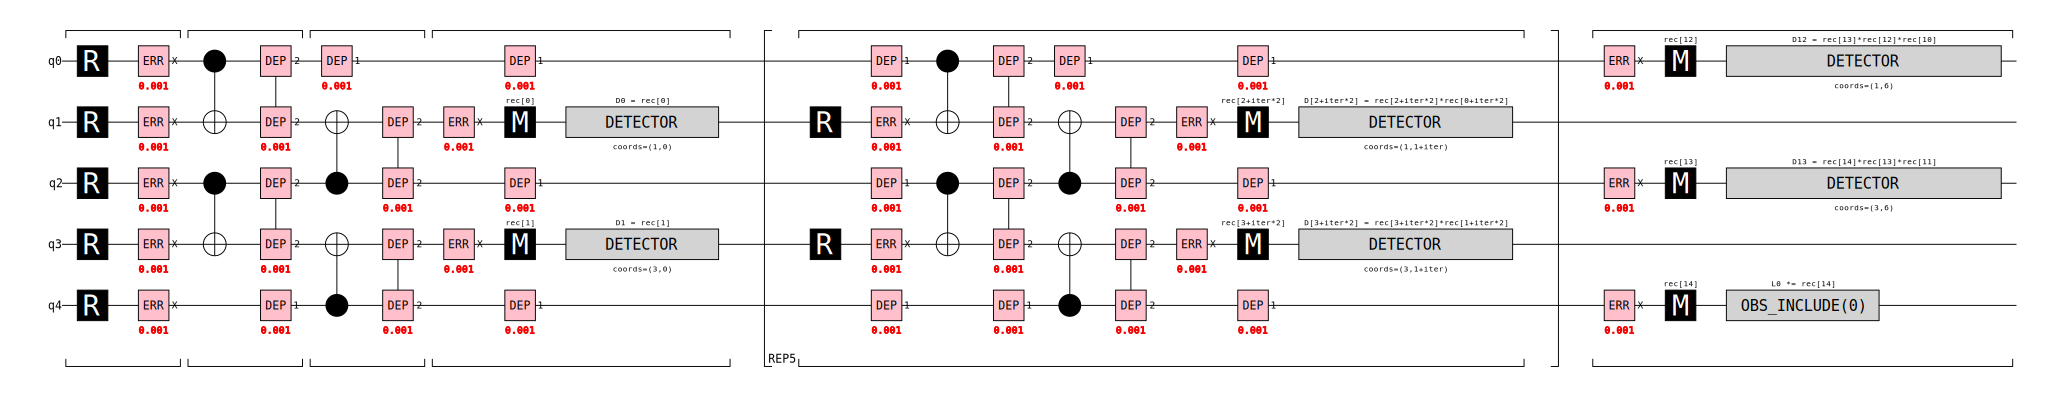

In [3]:
circuit = stim.Circuit(circDef1)
print(repr(circuit))
circuit.diagram('timeline-svg')

### use build-in circuit generator


In [4]:
circuit = stim.Circuit.generated(
"repetition_code:memory",
rounds=5,
distance=3,
before_round_data_depolarization=0.02)

stim.Circuit('''
    R 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.02) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    REPEAT 4 {
        TICK
        DEPOLARIZE1(0.02) 0 2 4
        CX 0 1 2 3
        TICK
        CX 2 1 4 3
        TICK
        MR 1 3
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')


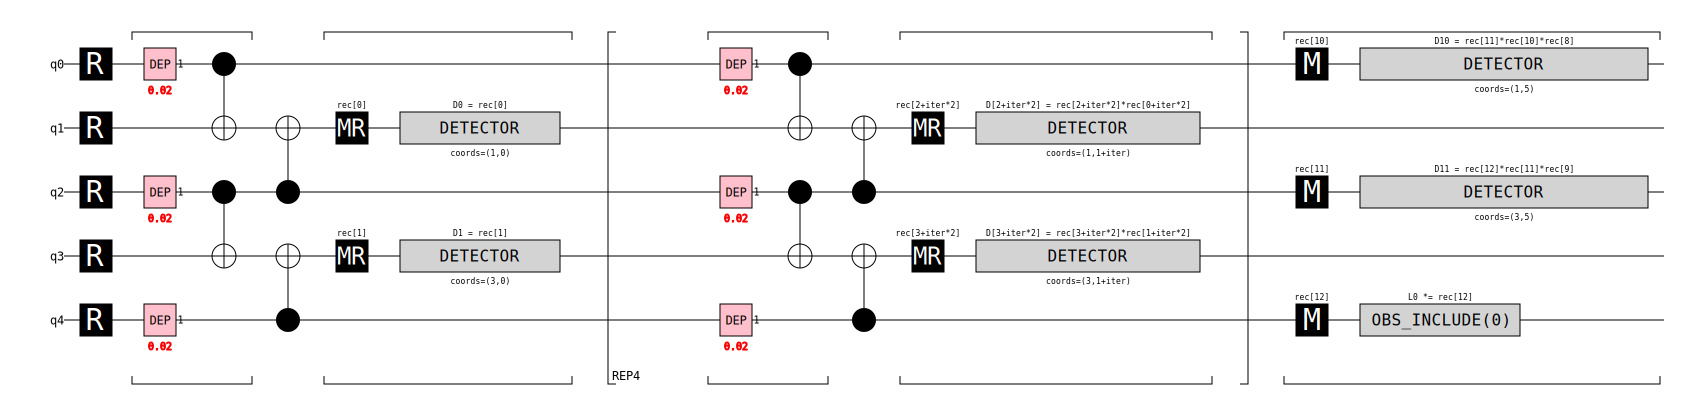

In [5]:
print(repr(circuit))
circuit.diagram('timeline-svg')

### generate logical error curves
see sect 7 of getting_started.ipynb

In [6]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

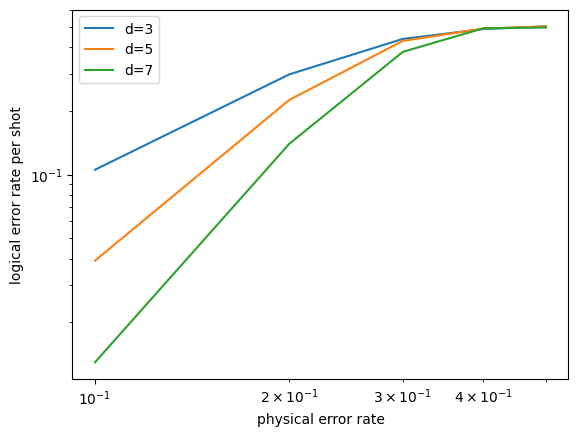

In [7]:

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

modify the new file so that the final round of measurements occurs at the same time as the second-to-last round of measurements. There is no reason we need to perform these in different time steps, which incurs unnecessary chances for errors.

In [8]:
# Our logical states are 000 and 111, so observing any single qubit tells us which logical state we have measured.

circDef2="""
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    TICK
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    REPEAT 4 {
        R 1 3
        X_ERROR(0.001) 1 3
        DEPOLARIZE1(0.001) 0 2 4
        TICK
        CX 0 1 2 3
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        TICK
        CX 2 1 4 3
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        TICK
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    R 1 3
    X_ERROR(0.001) 1 3
    DEPOLARIZE1(0.001) 0 2 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    TICK
    X_ERROR(0.001) 1 3 0 2 4
    M 1 3 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-5] rec[-7]
    DETECTOR(3, 0) rec[-4] rec[-6]
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
"""

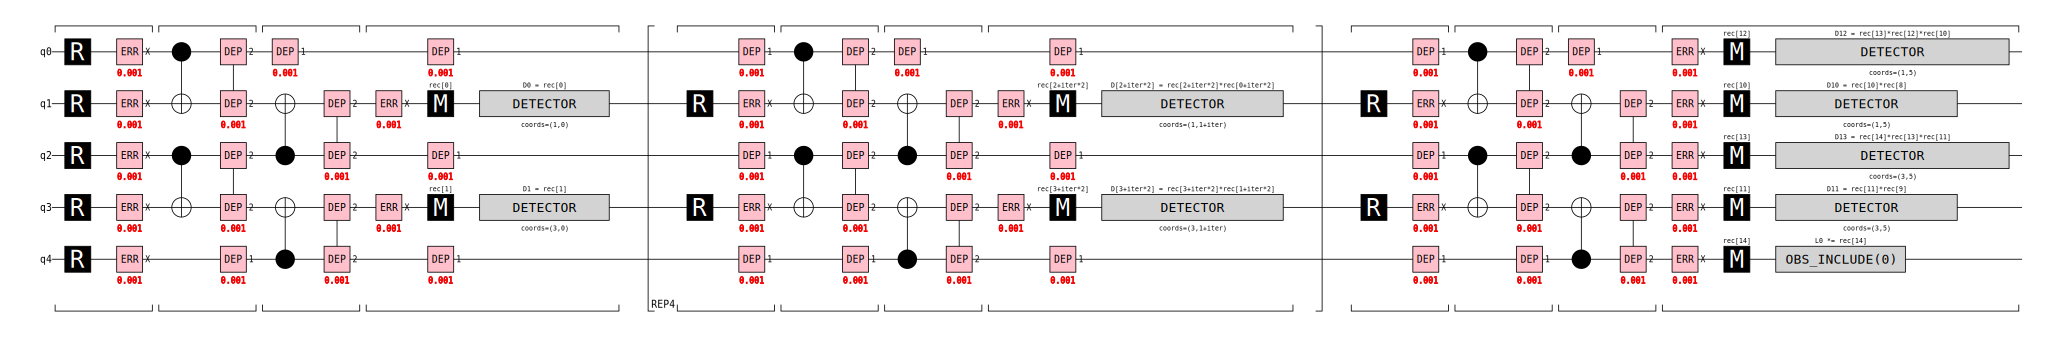

In [9]:
circuit = stim.Circuit(circDef2)
#rint(repr(circuit))
circuit.diagram('timeline-svg')

In [10]:
import stim

# Example circuit with measurements
c = stim.Circuit("""
R 1 3
M 1 3
M 0 1 2 3 4
""")

meas_counter = 0
for inst in c:
    if inst.name == "M":
        for q in inst.targets_copy():
            print(f"Measurement #{meas_counter}: qubit {q}")
            meas_counter += 1

Measurement #0: qubit stim.GateTarget(1)
Measurement #1: qubit stim.GateTarget(3)
Measurement #2: qubit stim.GateTarget(0)
Measurement #3: qubit stim.GateTarget(1)
Measurement #4: qubit stim.GateTarget(2)
Measurement #5: qubit stim.GateTarget(3)
Measurement #6: qubit stim.GateTarget(4)
